# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Условия задачи


* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

* Бюджет на разработку скважин в регионе — 10 млрд рублей.

* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

# Построение модели

## Загрузка и подготовка данных

### Описание данных

`id` — уникальный идентификатор скважины;

`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

`product` — объём запасов в скважине (тыс. баррелей).

### Загрузка данных

In [263]:
# импорт библиотек
import pandas as pd
import numpy as np

# загрузка данных о первой скважине
data_1 = pd.read_csv("./geo_data_0.csv")
print(data_1.info())
display(data_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [264]:
# загрузка данных о второй скважине
data_2 = pd.read_csv("./geo_data_1.csv")
print(data_2.info())
display(data_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [265]:
data_3 = pd.read_csv("./geo_data_2.csv")
print(data_3.info())
display(data_3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [266]:
# для удобства итераций запишем в один словарь все датасеты
data_all = {'data_1': data_1, 
            'data_2': data_2,
            'data_3': data_3}

### Подготовка данных

Представление данных во всех датасетах идентично, можно избавиться от столбца `id` и стандартизировать оставшиеся признаки: 

In [267]:
# удаление столбцов id
for df in data_all.values():
    try:
        df.drop('id', axis=1, inplace=True)
    except KeyError:
        pass

In [268]:
# импорт метода для стандартизации
from sklearn.preprocessing import StandardScaler

for df in data_all.values():
    scaler = StandardScaler()
    scaler.fit(df.drop('product', axis=1))
    df.loc[:, :'f2'] = scaler.transform(df.drop('product', axis=1))

## Обучение и проверка модели

Так как со всеми выборками потребуются одни и те же операции, обернем их внутрь функций:

In [269]:
# импорт метода для разделения
from sklearn.model_selection import train_test_split

# функция для разделения выборок
def split(df, test_size=0.25):
    features = df.drop('product', axis=1)
    target = df['product']
    f_train, f_val, t_train, t_val = train_test_split(features, target, test_size=test_size)
    return f_train, f_val, t_train, t_val

In [270]:
# импорт модели линейной регрессии
from sklearn.linear_model import LinearRegression

# функция для обучения модели
def train_model(df):
    # разделение выборки
    f_train, f_val, t_train, t_val = split(df)
    model = LinearRegression()
    model.fit(f_train, t_train)
    predictions = model.predict(f_val)
    # сохранение результатов предсказания и правильных ответов
    return predictions, t_val
    

In [271]:
# импорт метрики MSE
from sklearn.metrics import mean_squared_error   

# словарь для сохранения предсказаний
results = pd.DataFrame()
metrics_table = pd.DataFrame()
i = 0
for name, df in data_all.items():
    i += 1
    predictions, target = train_model(df)

    # сохранение валидационнх предсказаний и выборки
    results[f'{name} predictions'] = pd.Series(predictions)
    results[f'{name} target'] = target.reset_index(drop=True)

    # подсчет RMSE модели
    rooted_mean_squared_error = mean_squared_error(predictions, target) ** 0.5

    metrics_table[f'{i} скважина'] = pd.Series({
        'RMSE модели': rooted_mean_squared_error,
        'Средний запас предсказанного сырья': predictions.mean(),
        'Действительный средний запас сырья:': target.mean()
    })

metrics_table

,1 скважина,2 скважина,3 скважина
RMSE модели,37.546417,0.889853,40.154266
Средний запас предсказанного сырья,92.674740,68.798835,94.767177
Действительный средний запас сырья:,92.573113,68.798246,95.405294


Наиболее точные результаты предсказаний у модели, обученной на данных второй скважины, хотя наибольший запас сырья модель предсказала для третьей скважины, но ее RMSE сильно выше, то есть качество предсказаний модели сильно ниже

## Подготовка к расчёту прибыли

По условию, бюджет на разработку в регионе - 10 млрд. рублей, для удобства переведем все величины до третьего десятка, то есть 10 000 000 т. рублей, при этом каждый барель нефти стоит 450 т. рублей, в каждом регионе будут исследоваться 500 точек и разрабатываться 200 лучших из них, соответственно средняя прибыль = 450 * 200 * V, где V - предсказанный средний объем

Чтобы покрыть расходы, необходимый средний объем (в тысячах баррелей):

In [272]:
BUDGET = 10 ** 7
PRICE_PER_BARREL = 450
WELLS_NUM = 500
BEST_WELLS_NUM = 200 

MIN_AMOUNT =  BUDGET / PRICE_PER_BARREL 
MIN_MEAN_AMOUNT = MIN_AMOUNT / BEST_WELLS_NUM
print('Достаточный объем:', round(MIN_AMOUNT, 4))
print('Достаточный средний объем:', round(MIN_MEAN_AMOUNT, 4))

Достаточный объем: 22222.2222
Достаточный средний объем: 111.1111


Достаточный средний объем больше средних объемов всех точек в исследуемых регионах

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по предсказаниям модели:


In [273]:
def profit(predictions, target):
    try:
        # список лучших точек по предсказаниям
        predictions = predictions.sort_values(ascending=False)[:BEST_WELLS_NUM]
        # данные этих точек
        target = target[target.index.isin(predictions.index)]
        return target.sum() * PRICE_PER_BARREL
    except:
        print('Something went wrong')

Применим технику Bootstrap для оценки распределения прибыли:

In [274]:
state = np.random.RandomState(12)

# функция для подсчета распределения прибыли
def profit_distribution(predictions, target):
    # подсчет выручки
    revenues = []

    # применим bootstrap для 1000 выборок
    for j in range(1000):
        sub_predictions = predictions.sample(500, replace=True, random_state=state)
        revenues.append(profit(sub_predictions, target))
    
    # подсчет дохода в миллионах
    profits = pd.Series([(revenue - BUDGET) / 1000 for revenue in revenues])
    return profits

Подсчитаем риск убытков для каждого региона:

Для 1 скважины:
Вероятность убытков: 8.6%, более 2.5%:
Средняя прибыль: 380.4839340268645
Доверительный интервал: (-141.751664272005, 882.1476427500647)


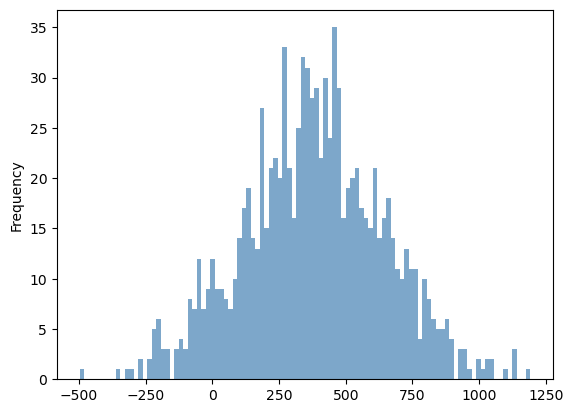

Для 2 скважины:
Вероятность убытков: 4.6%, более 2.5%:
Средняя прибыль: 361.46789588887236
Доверительный интервал: (-49.53815199242309, 780.3242469118245)


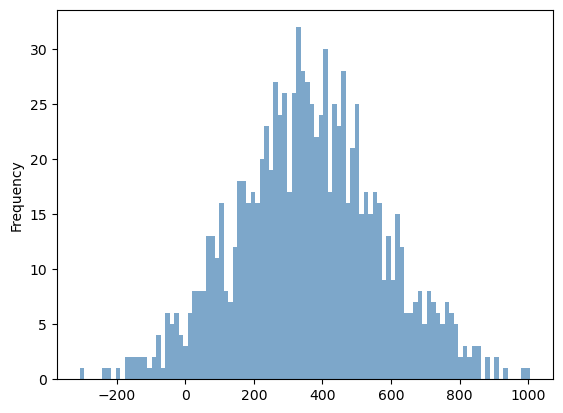

Для 3 скважины:
Вероятность убытков: 10.8%, более 2.5%:
Средняя прибыль: 331.95458973700875
Доверительный интервал: (-228.6307428329275, 832.9708785953969)


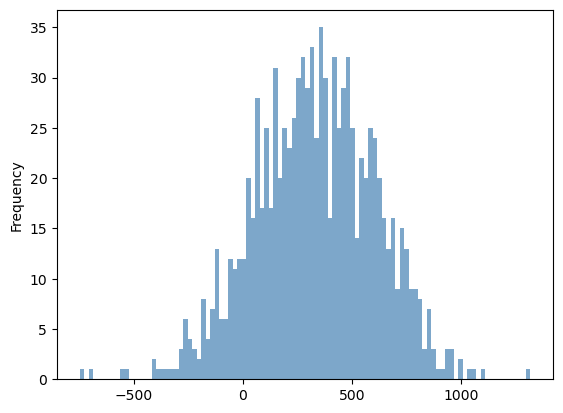

In [277]:
# импортируем библиотеку для графиков
from matplotlib import pyplot as plt

# доверительный интервал по условию
alpha = 0.025

# применим к каждому региону
i = 0
for name in data_all.keys():
    predictions = results[f'{name} predictions']
    target = results[f'{name} target']
    profits = profit_distribution(predictions, target)

    i += 1
    print('Для', i, 'скважины:')

    # подсчет вероятности убытков
    loss_count = (profits < 0).sum() / len(profits)
    if loss_count > alpha:
        print(f'Вероятность убытков: {loss_count * 100}%, более 2.5%:')
    else:
        print(f'Вероятность убытков: {loss_count * 100}%, меньше 2.5%')

    # подсчет доверительного интервала        
    lower = profits.quantile(0.025)
    higher = profits.quantile(0.975)

    print('Средняя прибыль:', sum(profits)/len(profits))    
    print(f'Доверительный интервал: ({lower}, {higher})')

    # график распределения
    plt.figure()
    profits.plot(kind='hist', bins=100, alpha=0.7, color='steelblue')
    plt.show()


## Вывод

Ни в одном регионе модель не может обеспечить вероятность убытков менее 2.5% при заданных условиях, можно предложить при разведке региона исследовать более 500 точек, чтобы потенциальная прибыль при отборе 200 лучших была в среднем выше